In [1]:
img_size = [227,227] #List which stores the resolution
main_train = '../input/crack-detection/Main/Train' #Stores the path of the train directory
main_test = '../input/crack-detection/Main/Test' #Stores the path of the test directory

# Import Statements

In [2]:
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications.inception_v3  import InceptionV3,preprocess_input
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# InceptionV3 Model Building

In [3]:
inceptionv3_model = InceptionV3(include_top=False,
    weights="imagenet",
    input_shape=img_size + [3])

# Loading the InceptionV3 pre trained model

# include_top - this specifies whether the final layer before the output layer has to be include 
# or not. If included then there will be 1000 number of classes at the output.

# Weights are trained using imagenet

2021-12-21 04:54:39.048759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 04:54:39.156750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 04:54:39.157458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 04:54:39.158540: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [4]:
# To print the hidden layer summary of inceptionv3 model without top layer
inceptionv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
# To fix the weights of the pre trained model
for lay in inceptionv3_model.layers:
    lay.trainable = False

In [6]:
inceptionv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
# to list out number of folders in train and test folder
import os
folders_train1 = os.listdir(main_train)
print(len(folders_train1))

folders_test1 = os.listdir(main_test)
print(len(folders_test1))

2
2


In [8]:
#outputs the last layer
inceptionv3_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

In [9]:
#inputs of the layer
inceptionv3_model.input

<KerasTensor: shape=(None, 227, 227, 3) dtype=float32 (created by layer 'input_1')>

In [10]:
# Flatten() is used to convert the last layer to vector or as fully connected
x = Flatten(name="first_flatten")(inceptionv3_model.output)
# Dense() is a fully connected layer and produces 128 outputs.
# relu layer is used to convert the negative nubers to 0 and retains +ve as such.
pred = Dense(128, activation="relu")(x)
#Dropout() layer is used to randomly remove 50% of the networks.
pred = Dropout(0.5)(pred)
# Dense() layer is added such that it outputs only two classess 
# Softmax activation layer produces probabilities for different classess.
pred = Dense(2,activation='softmax')(pred)
# Model() is used to group layers
model = Model(inputs=inceptionv3_model.input,outputs=pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Image Augmentation

In [11]:
#ImageDataGenerator is used to modify the train and test images w.r.t the properties mentioned
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip = True)

# flow_from_directory() is used to convert all the images in the specific directory
training_set = train_datagen.flow_from_directory(directory = main_train,
                                                 target_size = (227,227),
                                                 batch_size = 500,
                                                 )

test_set = test_datagen.flow_from_directory(directory = main_test,
                                                 target_size = (227,227),
                                                 batch_size = 500,
                                                 )

Found 32042 images belonging to 2 classes.
Found 7958 images belonging to 2 classes.


In [12]:
# Class_indices will display the respective class value
training_set.class_indices

{'Negative': 0, 'Positive': 1}

In [13]:
# To check no.of folders in each
print(len(training_set))
print(len(test_set))

65
16


# Model Fitting

In [14]:
# Loss function is used to find the errors or deviations in learning process
# Optimizer is used to optimize the input weights
# Metrics is used to measure the performance
model.compile(optimizer=Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=['accuracy'])

In [15]:
# fit() is used to train the model 
# len(training_set) is 32042/500 = 65
# len(test_set) is 7958/500 = 16
mod = model.fit(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

2021-12-21 04:55:06.500530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-12-21 04:55:17.758715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 599s 9s/step - loss: 3.0050 - accuracy: 0.8987 - val_loss: 0.0818 - val_accuracy: 0.9757
Epoch 2/2
65/65 [==============================] - 487s 8s/step - loss: 0.1032 - accuracy: 0.9545 - val_loss: 0.0464 - val_accuracy: 0.9874


# Model Saving

In [16]:
# To save the particular model in .h5 format
import tensorflow as tf
from tensorflow.keras.models import load_model
model.save('inception_v3.h5') 

# Visualizing the Result

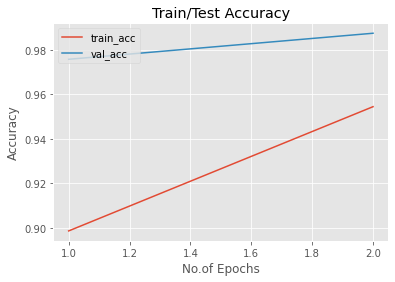

In [17]:
from matplotlib import pyplot as plt
# N represents the no.of Epochs
N = 2
# ggplot is the basic style frame work
plt.style.use("ggplot")
plt.figure()
# plot() is used to plot the graph with resp x & y values from history.
plt.plot(np.arange(1, N+1), mod.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), mod.history["val_accuracy"], label="val_acc")
# title() is used to display the heading for the graph.
plt.title("Train/Test Accuracy")
# xlabel() and ylabel() is used to print the axis titles.
plt.xlabel("No.of Epochs")
plt.ylabel("Accuracy")
# legend() is used to place axis details.
plt.legend(loc="upper left")
# to save the plot.
plt.savefig('accv1.png')

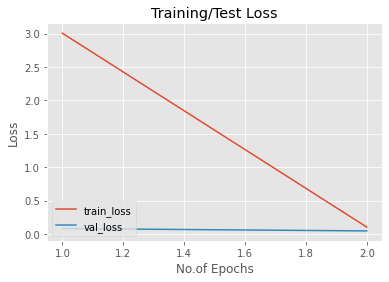

In [18]:
N = 2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, N+1), mod.history["loss"], label="train_loss")
plt.plot(np.arange(1, N+1), mod.history["val_loss"], label="val_loss")
plt.title("Training/Test Loss")
plt.xlabel("No.of Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('lossv1.png')